In [ ]:
using CUDA, Flux, cuDNN
using Flux: train!

In [2]:
f(x) = x^3 + sin(x)^2
x_train = (rand(1,2000).+1) |> gpu
y_train = f.(x_train) |> gpu
x_test = (rand(1,5).+1) |> gpu
y_test = f.(x_test) |> gpu
print("Prepare date")

Prepare date

In [3]:
model = Chain(Dense(1, 10), σ, Dense(10, 100), σ, Dense(100, 10), σ, Dense(10, 1)) |> gpu

Chain(
  Dense(1 => 10),                       # 20 parameters
  NNlib.σ,
  Dense(10 => 100),                     # 1_100 parameters
  NNlib.σ,
  Dense(100 => 10),                     # 1_010 parameters
  NNlib.σ,
  Dense(10 => 1),                       # 11 parameters
)                   # Total: 8 arrays, 2_141 parameters, 1.297 KiB.

In [4]:
loss(x, y) = Flux.Losses.mae(model(x), y)

loss (generic function with 1 method)

In [5]:
opt = Descent(0.1)

Descent(0.1)

In [6]:
data = [(x_train, y_train)]
for epoch in 1:10000
    train!(loss, Flux.params(model), data, opt)
    if epoch % 1000 == 0
        print("Epoch: ", epoch, "/20000  \t Loss: ", loss(x_train, y_train),"\n")
    end
end

opt = Descent(0.01)
for epoch in 1:10000
    train!(loss, Flux.params(model), data, opt)
    if epoch % 1000 == 0
        print("Epoch: ", epoch+10000, "/20000  \t Loss: ", loss(x_train, y_train),"\n")
    end
end

Epoch: 1000/20000  	 Loss: 1.711789
Epoch: 2000/20000  	 Loss: 0.375945
Epoch: 3000/20000  	 Loss: 0.68110204
Epoch: 4000/20000  	 Loss: 0.4163496
Epoch: 5000/20000  	 Loss: 0.35748342
Epoch: 6000/20000  	 Loss: 0.306952
Epoch: 7000/20000  	 Loss: 0.24068166
Epoch: 8000/20000  	 Loss: 0.23122382
Epoch: 9000/20000  	 Loss: 0.20235544
Epoch: 10000/20000  	 Loss: 0.18899499
Epoch: 11000/20000  	 Loss: 0.06921479
Epoch: 12000/20000  	 Loss: 0.061692834
Epoch: 13000/20000  	 Loss: 0.054462187
Epoch: 14000/20000  	 Loss: 0.046998538
Epoch: 15000/20000  	 Loss: 0.038667087
Epoch: 16000/20000  	 Loss: 0.028482154
Epoch: 17000/20000  	 Loss: 0.019433517
Epoch: 18000/20000  	 Loss: 0.016508557
Epoch: 19000/20000  	 Loss: 0.022179957
Epoch: 20000/20000  	 Loss: 0.022598846


In [7]:
y_test

1×5 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 8.00271  2.84713  4.77441  8.61522  8.54695

In [8]:
model(x_test)

1×5 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 8.00303  2.84115  4.73828  8.56607  8.50933

In [1]:
using Statistics
using Flux, Flux.Optimise
using MLDatasets: MNIST
using Images, ImageTransformations
using Flux: onehotbatch, onecold
using Flux: crossentropy, Momentum
using Base.Iterators: partition
using CUDA
using Plots

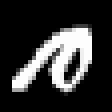

In [2]:
dataset = MNIST(split=:train, Tx=Float32)
one_image = dataset.features[:,:,rand(1:end)]
Images.colorview(Gray, one_image)

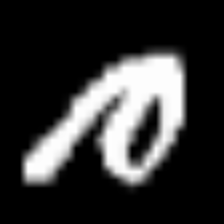

In [3]:
resized_image = imresize(one_image, (224, 224))
Images.colorview(Gray, resized_image)

In [4]:
train_x = imresize(dataset.features, (224, 224, 60000))
labels = onehotbatch(dataset.targets, 0:9)
train_x = reshape(train_x, 224, 224, 1, size(train_x, 3))
train = ([(train_x[:,:,:,i], labels[:,i]) for i in partition(1:59000, 1000)])
valset = 59000:60000
valX = train_x[:,:,:,valset] |> gpu
valY = labels[:, valset] |> gpu ;

In [5]:
m = Chain(
  Conv((11, 11), 1=>96, relu, stride=4, pad=(1,2,1,2)),
  MaxPool((3,3), stride=2),
  Conv((5,5), 96=>256, relu, stride=1, pad=2),
  MaxPool((3,3), stride=2),
  Conv((3,3), 256=>384, relu, stride=1, pad=1),
  Conv((3,3), 384=>384, relu, stride=1, pad=1),
  Conv((3,3), 384=>256, relu, stride=1, pad=1),
  MaxPool((3,3), stride=2),
  x -> reshape(x, :, size(x, 4)),
  Dense(256*6*6=>4096, relu),
  Dropout(0.5),
  Dense(4096=>4096, relu),
  Dropout(0.5),
  Dense(4096, 10),
  softmax) |> gpu

Chain(
  Conv((11, 11), 1 => 96, relu, pad=(1, 2, 1, 2), stride=4),  # 11_712 parameters
  MaxPool((3, 3), stride=2),
  Conv((5, 5), 96 => 256, relu, pad=2),  # 614_656 parameters
  MaxPool((3, 3), stride=2),
  Conv((3, 3), 256 => 384, relu, pad=1),  # 885_120 parameters
  Conv((3, 3), 384 => 384, relu, pad=1),  # 1_327_488 parameters
  Conv((3, 3), 384 => 256, relu, pad=1),  # 884_992 parameters
  MaxPool((3, 3), stride=2),
  var"#5#6"(),
  Dense(9216 => 4096, relu),            # 37_752_832 parameters
  Dropout(0.5),
  Dense(4096 => 4096, relu),            # 16_781_312 parameters
  Dropout(0.5),
  Dense(4096 => 10),                    # 40_970 parameters
  NNlib.softmax,
)                   # Total: 16 arrays, 58_299_082 parameters, 4.172 KiB.

In [6]:
loss(x, y) = sum(crossentropy(m(x), y))
accuracy(x, y) = mean(onecold(m(x), 0:9) .== onecold(y, 0:9))
opt = Momentum(0.01)

Momentum(0.01, 0.9, IdDict{Any, Any}())

In [7]:
epochs = 10

for epoch = 1:epochs
  for d in train
    gs = gradient(Flux.params(m)) do
      l = loss(gpu(d)...)
    end
    update!(opt, Flux.params(m), gs)
  end
  print("Epoch: ", epoch, "/10,  accuracy: ", accuracy(valX, valY),"\n")
end

Epoch: 1/10,  accuracy: 0.9560439560439561
Epoch: 2/10,  accuracy: 0.9790209790209791
Epoch: 3/10,  accuracy: 0.985014985014985
Epoch: 4/10,  accuracy: 0.987012987012987
Epoch: 5/10,  accuracy: 0.991008991008991
Epoch: 6/10,  accuracy: 0.991008991008991
Epoch: 7/10,  accuracy: 0.9920079920079921
Epoch: 8/10,  accuracy: 0.9920079920079921
Epoch: 9/10,  accuracy: 0.993006993006993
Epoch: 10/10,  accuracy: 0.993006993006993
